# Wrangle
In this notebook, we will gain a first overview of our data and wrangle it to make it usable for further analysis and modeling. 

## Imports

In [49]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from matplotlib import pyplot as plt

## Constants

In [4]:
RAW_DATA_PATH = "../data/raw/"
METEO_DATA_PATH = os.path.join(RAW_DATA_PATH, "gsoy")

# 1. Meteorological data
The data source is the [National Centers for Enviromental Information](https://www.ncei.noaa.gov/metadata/geoportal/rest/metadata/item/gov.noaa.ncdc:C00947/html) and contains 58 meteorological variables on a yearly frequency for locations worldwide.

## 1.1 Load data
The dataset contains multiple CSV files from different weather stations. We will first of all load all of those files and combine them to one data frame.

In [16]:
meteo_csv_files = list(
    filter(lambda fname: fname.endswith(".csv"), os.listdir(METEO_DATA_PATH))
)

print(f"{METEO_DATA_PATH} contains {len(meteo_csv_files)} CSV files.")

meteo_dfs = []
for fname in tqdm(meteo_csv_files, total=len(meteo_csv_files)):
    tmp_df = pd.read_csv(os.path.join(METEO_DATA_PATH, fname))
    meteo_dfs.append(tmp_df)

meteo_df_full = pd.concat(meteo_dfs)  # this will take a while!
meteo_df_full.head()

../data/raw/gsoy contains 82292 CSV files.


100%|████████████████████████████████████| 82292/82292 [04:09<00:00, 330.44it/s]


## 1.2 Select relevant variables
The dataset contains 58 meteorological variables which are further described [here](https://www.ncei.noaa.gov/data/global-summary-of-the-year/doc/GSOM_GSOY_Description_Document_v1.0.2_20200219.pdf). As some variables are available in Fahrenheit and Celsius, and some of them are not of interest for us, we will only select the relevant ones.

The ones that will be selected by us are:
- **STATION** - (11 characters) is the station identification code. 
- **NAME** - (max 50 characters) is the name of the station (usually city/airport name).
- **LATITUDE** - (8 characters) is the latitude (decimated degrees w/Northern Hemisphere values > 0).
- **LONGITUDE** - (9 characters) is the longitude (decimated degrees w/Western Hemisphere values < 0 and Eastern Hemisphere values > 0)
- **ELEVATION** - (13 characters) is the elevation above mean sea level in meters (to nearest thousandth of a meter).
- **DATE** - is the year of the record.
- **AWND** – Annual Average Wind Speed. Given in miles per hour.
- **DT00** – Number of days with minimum temperature <= 0 degrees Fahrenheit/-17.8 degrees Celsius.
- **DT32** – Number of days with minimum temperature <= 32 degrees Fahrenheit/0 degrees Celsius.
- **DX32** – Number of days with maximum temperature <= 32 degrees Fahrenheit/0 degrees Celsius.
- **DX70** – Number of days with maximum temperature <= 70 degrees Fahrenheit/21.1 degrees Celsius.
- **DX90** – Number of days with maximum temperature >= 90 degrees Fahrenheit/32.2 degrees Celsius.
- **DYTS** – Total number of days in the year where one or more thunderstorms were reported. 
- **EMNT** – Extreme minimum temperature for year. Lowest daily minimum temperature for the year. 
- **EMXP** – Highest daily total of precipitation in the year. Given in inches.
- **EMXT** – Extreme maximum temperature for year. Highest daily maximum temperature for the year. 
- **PRCP** – Total Annual Precipitation. Given in inches.
- **SNOW** – Total Annual Snowfall. Given in inches. 
- **TAVG** – Average Annual Temperature. Computed by adding the unrounded annual maximum (TMAX) and minimum (TMIN) temperatures and dividing by 2. Fahrenheit units.
- **TMAX** – Average Annual Maximum Temperature. Average of mean monthly maximum temperatures given in Fahrenheit.
- **TMIN** – Average Annual Minimum Temperature. Average of mean monthly minimum temperatures given in Fahrenheit.
- **TSUN** – Annual total sunshine in minutes.

In [43]:
relevant_vars = [
    "STATION",
    "NAME",
    "LATITUDE",
    "LONGITUDE",
    "ELEVATION",
    "DATE",
    "AWND",
    "DT00",
    "DT32",
    "DX32",
    "DX70",
    "DX90",
    "DYTS",
    "EMNT",
    "EMXP",
    "EMXT",
    "PRCP",
    "SNOW",
    "TAVG",
    "TMAX",
    "TMIN",
    "TSUN",
]
print(f"Shape before variable filtering: {meteo_df_full.shape}")
meteo_df_relevant = meteo_df_full[relevant_vars]
print(f"Shape after variable filtering: {meteo_df_relevant.shape}")

Shape before variable filtering: (2533245, 216)
Shape after variable filtering: (2533245, 22)


## 1.3 Select relevant years
To keep the dataset size managable, we will only consider observations with `DATE >= 1950`.

In [44]:
print(f"Shape before year filtering: {meteo_df_relevant.shape}")
meteo_df_relevant_year = meteo_df_relevant[meteo_df_relevant["DATE"] >= 1950]
print(f"Shape after year filtering: {meteo_df_relevant_year.shape}")

Shape before year filtering: (2533245, 22)
Shape after year filtering: (1849783, 22)


## 1.4 Examine missing values per variable

In [45]:
df = meteo_df_relevant_year

variable_descriptions = []
for var in df.columns.values:
    desc = {
        "variable": var,
        "ndv": df[var].nunique(),
        "missing_absolute": df[var].isna().sum(),
        "missing_relative": df[var].isna().sum() / len(df[var])
    }
    variable_descriptions.append(desc)
variable_descriptions = pd.DataFrame(variable_descriptions)
variable_descriptions

,variable,ndv,missing_absolute,missing_relative
0,STATION,76054,0,0.000000
1,NAME,73525,0,0.000000
2,LATITUDE,45316,0,0.000000
3,LONGITUDE,50015,0,0.000000
4,ELEVATION,8541,13084,0.007073
5,DATE,73,0,0.000000
6,AWND,150,1825412,0.986825
7,DT00,269,1136865,0.614594
8,DT32,367,1136865,0.614594
9,DX32,347,1122249,0.606692


We can see that there are a lot of missing values for all variables except the ones discribing the location and the date. Especially for `AWND`, `DYTS` and `TSUN` over 85% of the values are missing. Therefore, we will remove those variables, as we wont fix those with any imputation strategies. 



In [69]:
df = df.drop(["AWND", "DYTS", "TSUN"], axis=1)

## 1.5 Examine missing values per year
We will now investigate, if those missing values are randomly scattered or if they are only missing for certain years and stations.

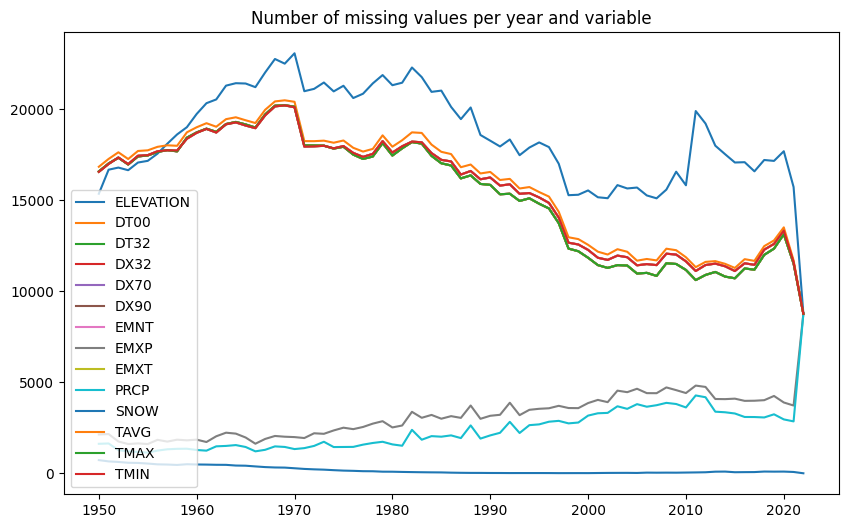

In [71]:
missing_per_year = df.groupby(["DATE"]).agg(lambda x: x.isna().sum())

fig, ax = plt.subplots(figsize=(10, 6))

missing_per_year
for var in missing_per_year.columns.values:
    if (missing_per_year[var] > 0).any():
        ax.plot(missing_per_year.index, missing_per_year[var], label=var)
ax.legend(loc="best")
ax.set_title("Number of missing values per year and variable")
plt.show()

We cannot observe a concrete year for which the number of missing values is a lot higher than for others. Therefore we cannot simple remove a year to get rid of missing values.

## 1.5 Examine missing values by station

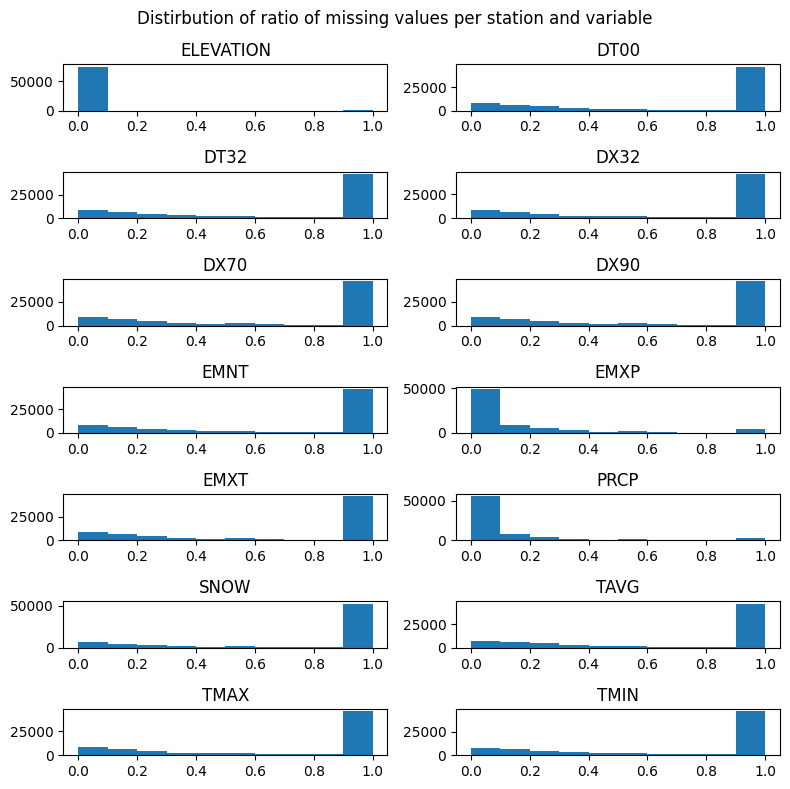

In [103]:
missing_per_location = df.groupby(["STATION"]).agg(lambda x: x.isna().sum() / len(x)) # we use the number of total values to normalize

num_missing_loc_vars = sum((missing_per_location > 0).any())

fig, axs = plt.subplots(num_missing_loc_vars//2, 2, figsize=(8, 8))
fig.suptitle("Distirbution of ratio of missing values per station and variable")
axs = axs.flatten()
idx = 0
for var in missing_per_location.columns.values:
    if sum(missing_per_location[var]) > 0:
        axs[idx].hist(missing_per_location[var])
        axs[idx].set_title(var)
        idx+=1
plt.tight_layout()
plt.show()

From the histograms above, we can observe that there are many stations where over 90% of values for a variable are missing. Especially `SNOW` which is missing for almost all stations at some point. We will take a closer look at those stations and then remove them. 

### 1.5.1 Investigate stations with high number of missing values

In [121]:
print(f"Number of stations: {len(missing_per_location)}")
print(f"Number of stations with any variable >90% missing: {len(missing_per_location[missing_per_location > 0.9])}")
mpl_no_snow = missing_per_location.drop(["SNOW"], axis=1) 
print(f"Number of stations with any variable (without SNOW) >90% missing: {len(mpl_no_snow[mpl_no_snow > 0.9])}")



Number of stations: 76054
Number of stations with any variable >90% missing: 76054
Number of stations with any variable (without SNOW) >90% missing: 76054


We can see that even when we remove `SNOW` and and select all observations where >90% of values are missing for one variable, all stations would be affected. In other words, each station has a variable for which all values are missing. This means, we cannot use the missing values per stations to remove missing values. 

## 1.6 Find country by coordinates

# 2. Enviromental and economical variables
and the [National Centers for Enviromental Information](https://www.ncei.noaa.gov/metadata/geoportal/rest/metadata/item/gov.noaa.ncdc:C00947/html).